In [1]:
import pandas as pd
import numpy as np
from random import gauss
from math import exp, sqrt
import math
import datetime
import matplotlib.pyplot as plt
from WindPy import w
w.start()

Welcome to use Wind Quant API for Python (WindPy)!

COPYRIGHT (C) 2020 WIND INFORMATION CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


.ErrorCode=0
.Data=[OK!]

In [2]:
def getDatesList(beginningDate, endingDate):
    """
    获取日期序列，return a list of dates

    参数：
        起始日期，终止日期
        
    返回值：
        这段日期的交易日，格式为list
    """
    #从wind获取datetime列表
    w.isconnected()
    
    #日期list
    datesListInDatetime = w.tdays(beginningDate, endingDate, "").Data[0]
    return datesListInDatetime

In [3]:
def getStockData(startDate, endDate, stockCode):
    """
    获取某个指数某一段时间的收盘价格，返回值为WindData

    参数：startDate：起始日期，字符串格式
           endDate：终止日期，字符串格式
         benchmark：需要查询的指数或者股票代码，字符串格式

    返回值：WindData，e.g.
          .ErrorCode=0
          .Codes=[000905.SH]
          .Fields=[CLOSE]
          .Times=[20201201,20201202,20201203,20201204,20201207,20201208,20201209,20201210,20201211]
          .Data=[[6426.6155,6434.9791,6440.8808,6464.7345,6424.6823,6423.6513,6307.2207,6320.0956,6209.427]]
    """
    w.isconnected()
    closingData = w.wsd(stockCode, "close", startDate, endDate, "")
    return closingData

In [4]:
def calculateStockPriceVolatility(stockCode, startDate, endDate, tradingDaysPerYear):
    """
    计算标的在一段时间内的年化波动率
    stockCode: 标的代码
    startDate: 开始日期
    endDate: 结束日期
    tradingDaysPerYear: 一年交易日天数
    """
    closingPrice = getStockData(startDate, endDate, stockCode).Data[0]
    
    dailyReturn = [0]
    continuousCompoundReturn = [0]
    for i in range(1, len(closingPrice)):
        dailyReturn.append(closingPrice[i] / closingPrice[i - 1])
        continuousCompoundReturn.append(math.log(dailyReturn[i]))
    
    continuousCompoundReturnAvg = sum(continuousCompoundReturn) / len(closingPrice) # miu
    
    # calculate (LN(R) - miu) ^ 2
    thetaFangList = [0]
    for j in continuousCompoundReturn:
        thetaFangList.append(pow(j - continuousCompoundReturnAvg, 2))
    variance =  sum(thetaFangList) / (len(closingPrice) - 1) # 样本方差theta^2
    standardDeviation = pow(variance, 0.5)   #标准差，即波动率
    annualVolatility = standardDeviation * sqrt(tradingDaysPerYear)
    return annualVolatility

In [5]:
def calculate_S_T(stockClosingPrice, stockPriceVolatility, riskFreeRate, daysToExpire):
    """模拟epsilon，计算S_T
    stockClosingPrice：测试当日的标的价格
    """
    return stockClosingPrice * exp((riskFreeRate - 0.5 * stockPriceVolatility ** 2) * daysToExpire + stockPriceVolatility * sqrt(daysToExpire) * gauss(0.0, 1.0))

In [6]:
def option_payoff(flag, S_T, strkingPrice):
    """期权收益"""
    if flag.lower() == 'call':
        return max(S_T - strkingPrice, 0.0)
    else:
        return max(strkingPrice - S_T, 0.0)

In [7]:
def option_price(flag, stockClosingPrice, riskFreeRate, daysToExpire, stockPriceVolatility, strkingPrice, simulations):
    """模拟
    flag： call/put
    stockClosingPrice：测试日当日的标的收盘价
    riskFreeRate: 无风险利率
    daysToExpire：期权距离到期的天数
    stockPriceVolatility: 波动率
    strkingPrice: 期权行权价
    simulations: 蒙特卡洛模拟次数
    """
    payoffs = []
    discout = exp(-riskFreeRate * daysToExpire)
    for i in range(simulations):
        S_T = calculate_S_T(stockClosingPrice, stockPriceVolatility, riskFreeRate, daysToExpire)
        payoffs.append(
            option_payoff(flag, S_T, strkingPrice)
        )
    price = discout * sum(payoffs) / float(simulations)
    return price

In [8]:
def drawLineChartActualOptionPriceVsCalculatedPrice(x_data, y_data1, data1Name, y_data2, data2Name):
    """
    画折线图，比较定价结果和实际期权价格
    """
    #解决中文显示问题
    plt.rcParams['font.sans-serif']=['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    
    plt.plot(x_data, y_data1, color = 'red',linewidth = 2.0, label = data1Name)
    plt.plot(x_data, y_data2, color = 'blue',linewidth = 3.0, label = data2Name)
    
    plt.xlabel('日期')
    plt.ylabel('价格')
    plt.title('期权定价与实际价格对比')
    plt.xticks(rotation = 30)          
    plt.legend()
    
    plt.show()

In [9]:
def getOnePredictionLine(beginningDate, endingDate, stockCode, riskFreeRate):
    beginningDateClosingPrice = getClosingPrice(stockCode)
    oneLine = [beginningNumber]
    stockPriceVolatility = calculateStockPriceVolatility(stockCode, testingDate_dt + datetime.timedelta(days = -365), 
                                                         testingDate_dt + datetime.timedelta(days = -1), TRADING_DATES_PER_YEAR)
    
    for testingDate_dt in allTradingDays_dt:
        calculate_S_T(beginningDateClosingPrice, stockPriceVolatility, riskFreeRate, 1)

In [10]:
def getPredictedStockClosingPrice(stockClosingPrice, stockPriceVolatility, riskFreeRate, daysToExpire):
    """
    已知t日标的收盘价，t日往前一年的收盘价算出的波动率，无风险利率，以及t日至T日的天数，计算T日标的价格
    
    """

In [11]:
# #===========参数设置================#
# RISK_FREE_RATE = 2.9000 / 100
# EXPIRE_DATE = "2021-03-19"
# TODAY_DATE = "2020-12-04"

# EXPIRE_DATE_dt = datetime.datetime.strptime(EXPIRE_DATE, '%Y-%m-%d')
# TODAY_DATE_dt = datetime.datetime.strptime(TODAY_DATE, '%Y-%m-%d')
                                
# DAYS_TO_EXPIRE = ((EXPIRE_DATE_dt - TODAY_DATE_dt).days)/365
# STOCK_CODE = "000300.SH"
# SIMULATIONS = 500000
# tradingPerYear = 240

# # 从START_DATE 到END_DATE 计算这段时间的volatility
# END_DATE_dt = TODAY_DATE_dt + datetime.timedelta(days = -1)
# START_DATE_dt = END_DATE_dt + datetime.timedelta(days = -365)

# END_DATE = END_DATE_dt.strftime('%Y-%m-%d')
# START_DATE = START_DATE_dt.strftime('%Y-%m-%d')

# STOCK_CLOSING_PRICE_DATE = END_DATE

# # 执行价格
# # STRIKING_PRICE = w.wss(STOCK_CODE, "close","tradeDate=20200623;priceAdj=U;cycle=D").Data[0][0]
# STRIKING_PRICE = 4500
# STOCK_CLOSING_PRICE = w.wss(STOCK_CODE, "close", "tradeDate=" + END_DATE + ";priceAdj=U;cycle=D").Data[0][0]
# FLAG = "call"

# stockPriceVolatility = calculateStockPriceVolatility(STOCK_CODE, START_DATE, END_DATE, tradingPerYear)


# result = option_price(FLAG, STOCK_CLOSING_PRICE, RISK_FREE_RATE, DAYS_TO_EXPIRE, stockPriceVolatility, STRIKING_PRICE, SIMULATIONS)
# # print(option_price('call', STOCK_CLOSING_PRICE, RISK_FREE_RATE, DAYS_TO_EXPIRE, stockPriceVolatility, STRIKING_PRICE, SIMULATION))
# # print(option_price('put', STOCK_CLOSING_PRICE, RISK_FREE_RATE, DAYS_TO_EXPIRE, stockPriceVolatility, STRIKING_PRICE, SIMULATIONS))
# # St = calculate_S_T(STOCK_CLOSING_PRICE, stockPriceVolatility, RISK_FREE_RATE, DAYS_TO_EXPIRE)
# result

2020-08-24的定价已计算: 603.8733692742479
2020-08-25的定价已计算: 608.3680216910706
2020-08-26的定价已计算: 558.097297412017
2020-08-27的定价已计算: 579.7556315687764
2020-08-28的定价已计算: 682.2154763574009
2020-08-31的定价已计算: 655.4221874487708
2020-09-01的定价已计算: 677.8137825804183
2020-09-02的定价已计算: 678.7491838424993
2020-09-03的定价已计算: 653.0090903568388
2020-09-04的定价已计算: 609.6154940387419
2020-09-07的定价已计算: 515.978721978865
2020-09-08的定价已计算: 538.3939528670942
2020-09-09的定价已计算: 440.632892678719
2020-09-10的定价已计算: 439.6791461589136
2020-09-11的定价已计算: 477.0964245183016
2020-09-14的定价已计算: 495.6372675441945
2020-09-15的定价已计算: 526.8821401439169
2020-09-16的定价已计算: 497.7475431760206
2020-09-17的定价已计算: 476.15177235315
2020-09-18的定价已计算: 568.9186540812077
2020-09-21的定价已计算: 526.3440717428999
2020-09-22的定价已计算: 474.3799378394556
2020-09-23的定价已计算: 488.3982068055478
2020-09-24的定价已计算: 409.0382635953231
2020-09-25的定价已计算: 414.0510901001134
2020-09-28的定价已计算: 421.4835817838283
2020-09-29的定价已计算: 428.87472356908523
2020-09-30的定价已计算: 424.4322042937

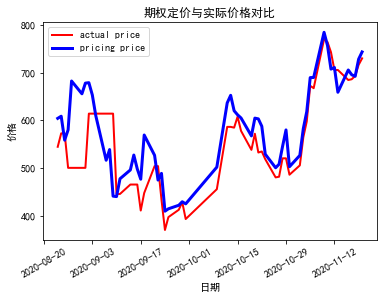

In [12]:
"""测试测试测试！！！"""

"""测试的期权信息：
沪深300指数期权2011C4200
上市日：2020-08-24
到期日：2020-11-20
行权价：4200

对8.24 - 11.20的期权价格进行定价，
"""

"""期权参数设置，需要手动填写"""
OPTION_CODE = "IO2011-C-4200.CFE"
STOCK_CODE = "000300.SH"
RISK_FREE_RATE = 2.3529 / 100
SIMULATIONS = 1000000
TRADING_DATES_PER_YEAR = 240

"""获取期权开始和到期日"""
optionData = w.wss(OPTION_CODE, "startdate, exe_enddate, exe_price, exe_mode").Data #获取期权开始和到期日，行权价格
OPTION_START_DATE_dt = optionData[0][0]
OPTION_STRIKE_DATE_dt = optionData[1][0]

OPTION_START_DATE = OPTION_START_DATE_dt.strftime('%Y-%m-%d')
OPTION_STRIKE_DATE = OPTION_STRIKE_DATE_dt.strftime('%Y-%m-%d')

allTradingDays_dt = w.tdays(OPTION_START_DATE_dt, OPTION_STRIKE_DATE_dt, "").Data[0]

"""获取期权的行权方式，结果为认购/认沽"""
FLAG = "CALL"
if(optionData[3][0] == "认沽"):
    FLAG = "PUT"

"""获取期权行权价格"""
STRIKING_PRICE = optionData[2][0]

"""获取期权上市期间每一天的实际收盘价"""
optionClosingPrice = w.wsd(OPTION_CODE, "close", OPTION_START_DATE, OPTION_STRIKE_DATE, "").Data[0] #获取期权在某一段时间的收盘价

"""创建测试价格list用来存每一天的定价结果"""
testingPriceResults = []

for testingDate_dt in allTradingDays_dt:
    stockClosingPrice = w.wsd("000300.SH", "close", testingDate_dt, testingDate_dt, "").Data[0][0]
    daysToExpire = (OPTION_STRIKE_DATE_dt - testingDate_dt).days / 365
    stockPriceVolatility = calculateStockPriceVolatility(STOCK_CODE, testingDate_dt + datetime.timedelta(days = -365), 
                                                         testingDate_dt + datetime.timedelta(days = -1), TRADING_DATES_PER_YEAR)
#     print(testingDate_dt.strftime('%Y-%m-%d') + " 沪深300收盘价：" + str(stockClosingPrice) + " 无风险利率： " + 
#           str(RISK_FREE_RATE) + " 剩余天数：" + str(daysToExpire) + " 波动率： " + str(stockPriceVolatility))
    optionPriceCalculated = option_price(FLAG, stockClosingPrice, RISK_FREE_RATE, daysToExpire, stockPriceVolatility, STRIKING_PRICE, SIMULATIONS)
    testingPriceResults.append(optionPriceCalculated)
    print(testingDate_dt.strftime('%Y-%m-%d') + "的定价已计算: " + str(optionPriceCalculated))
    
    
testingPriceResults    
"""画折线图，比较定价结果和实际期权价格"""
drawLineChartActualOptionPriceVsCalculatedPrice(allTradingDays_dt, optionClosingPrice, "actual price", testingPriceResults, "pricing price")    

# 文字解释部分

以每股苹果股票为标的的期权定价例子：

https://zhuanlan.zhihu.com/p/134759744

用19.4.23 - 20.4.23的股价计算波动率，

谷歌得到一年期的无风险利率r=0.16%

找出苹果公司期权的最新报价。即还有58天到期的期权

距离行权日还有T年（如果是n“天”，那么把n化成n/365年），到期日标的资产价格为 S(T)，标的资产行权价格为K，那么在行权日T时刻，期权的价格为：

Call option： C(T) = max(0, S(T) - K)

Put option：  P(T) = max(0, K - S(T))

使用蒙卡模拟进行期权定价，需要在风险中性环境中（风险中性定价原则认为1、标的资产的预期收益率=无风险利率，2、从而对未来的现金流进行无风险利率折现

因此在第t日，期权的价格为距离到期日T的预期收益折现值

![](optionPricingEquation.png)

接下来，我们需要对股价S(T)进行模拟。在BS模型中，股价服从几何布朗运动，推导得到

![](optionPricingEquation2.png)




Reference:

Code and Finance 2 蒙特卡洛模拟期权定价 - 苹果公司例子 https://zhuanlan.zhihu.com/p/134759744

场外期权系列——鲨鱼鳍期权的蒙特卡洛定价 https://zhuanlan.zhihu.com/p/163862299?utm_source=wechat_session

鲨鱼鳍期权定价、风险对冲和理财产品 https://www.gfedu.cn/aqf/content_22650.shtml

兴业证券 - 鲨鱼鳍期权及其理财产品 http://www.doc88.com/p-9082540939123.html

场外期权系列——鲨鱼鳍期权的蒙特卡洛定价 https://www.jianshu.com/p/5d4bf6e7d426

沪深300期权价格
http://www.cffex.com.cn/hs300gzqq/

暨南大学论文：http://www.doc88.com/p-9965019376435.html

入门期权隐含波动率计算 https://zhuanlan.zhihu.com/p/139521048


https://zhuanlan.zhihu.com/p/24482145

ModuleNotFoundError: No module named 'longstaffLeastSquares'